In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import wave
import yaml
from matplotlib.pyplot import imshow
from os import listdir
from os.path import isfile, join
%matplotlib inline
%reload_ext autoreload
%autoreload

In [20]:
!pwd

/Users/spastukhov/Documents/ds/aihackathon2017/AI-Hackathon/notebooks/speech_to_text


In [2]:
video_file = 'Demo of Online Meeting via Zoom with Participants from Around the World-261OCjeg9GI.mp4'
with open('../../../../api_keys.yml', 'r') as f:
    keys = yaml.load(f)

Read a new frame:  True


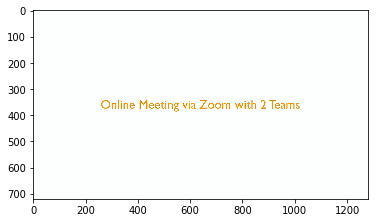

(16376.0, 30.0)
Number of frames: 16376
Duration 545866.666667 ms


In [3]:
vidcap = cv2.VideoCapture(video_file)
success, image = vidcap.read()
print 'Read a new frame: ', success
plt.imshow(image)
plt.show()
# cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
print(vidcap.get(cv2.CAP_PROP_FRAME_COUNT), vidcap.get(cv2.CAP_PROP_FPS))
totalnoframes = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
totaldurationms = 1000*totalnoframes/vidcap.get(cv2.CAP_PROP_FPS)
print('Number of frames: %i' % totalnoframes)
print('Duration %f ms' % totaldurationms)
vidcap.release()


In [ ]:
# Convert video to audiofiles
for ss in range(0, int(totaldurationms), 9000):
    hhmmss = time.strftime('%H:%M:%S', time.gmtime(ss / 1000))
    outfile = 'wavs/%s.%s.wav' % (video_file, ss)
    !ffmpeg -y -i '$video_file' -ac 1 -ar 16000 -ss $hhmmss -t 00:00:10.0 -q:a 0 -map a '$outfile' &> /dev/null
    if (int(ss) % 90000 == 0):
        print('Processed %s' % hhmmss)

In [18]:
import requests
import httplib
import uuid
import json

class Microsoft_ASR():
    def __init__(self, binq_key):
        self.sub_key = binq_key
        self.token = None
        pass

    def get_speech_token(self):
        FetchTokenURI = "/sts/v1.0/issueToken"
        header = {'Ocp-Apim-Subscription-Key': self.sub_key}
        conn = httplib.HTTPSConnection('api.cognitive.microsoft.com')
        body = ""
        conn.request("POST", FetchTokenURI, body, header)
        response = conn.getresponse()
        str_data = response.read()
        conn.close()
        self.token = str_data
#         print "Got Token: ", self.token
        return True

    def transcribe(self, speech_file):

        # Grab the token if we need it
        if self.token is None:
            print "No Token... Getting one"
            self.get_speech_token()

        endpoint = 'https://speech.platform.bing.com/recognize'
        request_id = uuid.uuid4()
        # Params form Microsoft Example 
        params = {'scenarios': 'ulm',
                  'appid': 'D4D52672-91D7-4C74-8AD8-42B1D98141A5',
                  'locale': 'en-US',
                  'version': '3.0',
                  'format': 'json',
                  'instanceid': '565D69FF-E928-4B7E-87DA-9A750B96D9E3',
                  'requestid': uuid.uuid4(),
                  'device.os': 'linux'}
        content_type = "audio/wav; codec=""audio/pcm""; samplerate=16000"

        def stream_audio_file(speech_file, chunk_size=1024):
            with open(speech_file, 'rb') as f:
                while 1:
                    data = f.read(1024)
                    if not data:
                        break
                    yield data

        headers = {'Authorization': 'Bearer ' + self.token, 
                   'Content-Type': content_type}
        resp = requests.post(endpoint, 
                            params=params, 
                            data=stream_audio_file(speech_file), 
                            headers=headers)
        
        try:
            val = json.loads(resp.text)
            return val["results"][0]["name"], val["results"][0]["confidence"]        
        except:
            print('Unknown error for file ' + speech_file)
            print(resp.text)
            return ('', 0)

In [19]:
# Convert all the wavs files to texts
ms_asr = Microsoft_ASR(keys['binq_voice_key_1'])
ms_asr.get_speech_token()

speech_data = []
for filename in listdir('wavs'):
    ss = filename.split('.')[-2]
    text, confidence = ms_asr.transcribe('wavs/' + filename)
    speech_data.append({'start_second': ss, 'text': text, 'confidence': confidence})

Unknown error for file wavs/Demo of Online Meeting via Zoom with Participants from Around the World-261OCjeg9GI.mp4.225000.wav
{"version":"3.0","header":{"status":"error","properties":{"requestid":"28d4cb5f-d75b-4215-ac79-8acaf12e44ba","FALSERECO":"1"}}}


ValueError: No JSON object could be decoded

In [14]:
speech_data = pd.DataFrame(speech_data)
speech_data


,confidence,start_second,text
0,0.8694921,0,here is an example of an online meeting with 2...
